In [1]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from pathlib import Path

# from torch.utils.data import Dataset

from pathlib import Path
import os

# from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import numpy as np

import random

import tensorflow as tf
import datetime, os

print_config()

2024-03-30 12:58:51.778725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 12:58:52.592094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

Fo

In [2]:
import os
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
print(directory)
root_dir = Path("/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY")
print(root_dir)
data_dir = os.path.join(root_dir, "Task09_Spleen")

None
/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY


In [3]:
class CTDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image_file = np.load(str(image_filepath))

        path_elements = list(Path(image_filepath).parts)
        index = path_elements.index('scans')
        path_elements[index] = 'airways'

        mask_filepath = os.path.join(*path_elements)
        mask_file = np.load(str(mask_filepath))

        if self.transform is not None:
            transformed_images = []
            transformed_masks = []
            for i in range(0, image_file.shape[-1]):
                
                image_slice = image_file[..., i]
                mask_slice = mask_file[..., i]

                transformed = self.transform(image=image_slice, mask=mask_slice)

                transformed_images.append(transformed["image"])
                transformed_masks.append(transformed["mask"])

            image_file = torch.stack(transformed_images, dim=0)
            mask_file = torch.stack(transformed_masks, dim=0).type(torch.float16)
            mask_file = mask_file.unsqueeze(0)

            image_file = image_file.permute(1, 0, 2, 3)

        return image_file, mask_file

In [20]:
class CTDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=96, width=96),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2()
        ])
        self.transforms = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=96, width=96),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.path_to_file = '/home/pawel/Documents/RISA/3D_segmentation/dataset'


    def prepare_data(self):
        if os.path.exists(self.path_to_file):
            print("Path exists")
            images_paths = sorted(Path(self.path_to_file).rglob('*.npy'))
            for image_path in images_paths:
                image = np.load(str(image_path))

                if image is None:
                    print("Unlink image: ", image_path)
                    image_path.unlink()
        else:
            print("Path does not exist")


    def setup(self, stage):
        paths = sorted(Path(os.path.join(self.path_to_file, 'scans')).glob('*.npy'))

        self.train_paths, self.val_paths = train_test_split(paths, test_size=0.3, random_state=42)

        self.train_ds = CTDataset(self.train_paths, transform=self.augmentations)
        self.val_ds = CTDataset(self.val_paths, transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
                            batch_size=30,
                            shuffle=True,
                            num_workers=6,
                            collate_fn=list_data_collate
                        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=20, num_workers=6)

## Visualization

Path exists
image shape: torch.Size([32, 64, 64]), label shape: torch.Size([32, 64, 64])


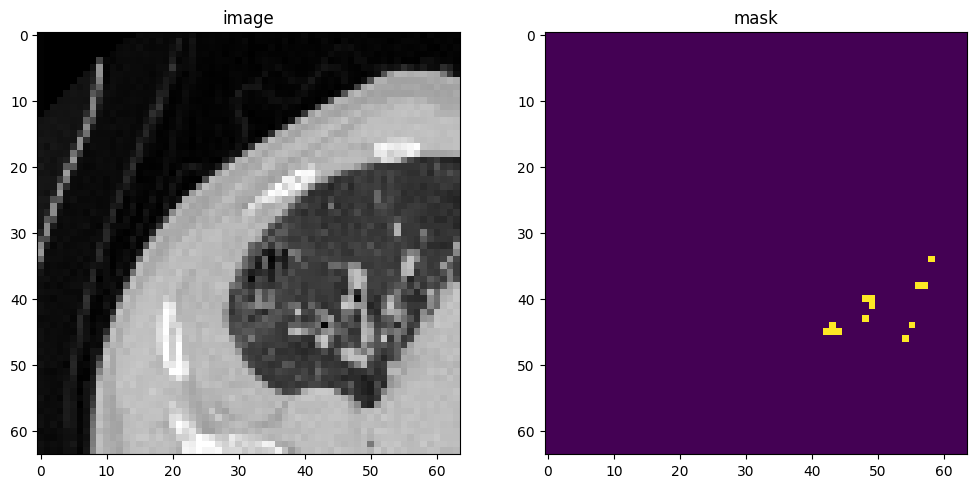

In [6]:
dataModule = CTDataModule()
dataModule.prepare_data()
dataModule.setup('fit')
val_dataset = dataModule.val_ds

object_number = random.randint(0, len(val_dataset)-1)

image, mask = val_dataset.__getitem__(object_number)
image = image.squeeze(0)
mask = mask.squeeze(0)

slice_number = random.randint(0, image.shape[0]-1)

print(f"image shape: {image.shape}, label shape: {mask.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[slice_number, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("mask")
plt.imshow(mask[slice_number, :, :])
plt.show()

In [5]:
from x_unet import XUnet

class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2, 2),
            num_res_units=3,
            norm=Norm.BATCH,
        )

        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # print(images.shape)
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        self.log('train_loss', loss, prog_bar=True)
        # self.accuracy.update(output, labels)
        # self.log('train_acc', self.accuracy, prog_bar=True)
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        roi_size = (32, 32, 32)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        self.log('val_loss', loss, prog_bar=True)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

In [16]:
# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

In [10]:
# initialise the LightningModule
net = Net()

checkpoint_path = '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_156-0.40247.ckpt'
net = Net.load_from_checkpoint(checkpoint_path)

data_module = CTDataModule()

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=600,
    callbacks= pytorch_lightning.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, save_last=False, verbose=True, dirpath='./checkpoints', filename='epoch_{epoch}-{val_loss:.5f}',  auto_insert_metric_name=False),
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# train
trainer.fit(net, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Path exists


/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 28.7 M
1 | loss_function | DiceLoss | 0     
-------------------------------------------
28.7 M    Trainable params
0         Non-trainable params
28.7 M    Total params
114.906   Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.97it/s]current epoch: 0 current mean dice: 0.3885
best mean dice: 0.3885 at epoch: 0
Epoch 0: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.314]current epoch: 0 current mean dice: 0.3191
best mean dice: 0.3885 at epoch: 0
Epoch 0: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.314, val_loss=0.411]

Epoch 0, global step 20: 'val_loss' reached 0.41057 (best 0.41057), saving model to '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_0-0.41057.ckpt' as top 1


Epoch 1: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.385, val_loss=0.411]current epoch: 1 current mean dice: 0.3393
best mean dice: 0.3885 at epoch: 0
Epoch 1: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.385, val_loss=0.404]

Epoch 1, global step 40: 'val_loss' reached 0.40399 (best 0.40399), saving model to '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_1-0.40399.ckpt' as top 1


Epoch 2: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.370, val_loss=0.404]current epoch: 2 current mean dice: 0.3113
best mean dice: 0.3885 at epoch: 0
Epoch 2: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.370, val_loss=0.412]

Epoch 2, global step 60: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s, v_num=26, train_loss=0.276, val_loss=0.412]current epoch: 3 current mean dice: 0.3325
best mean dice: 0.3885 at epoch: 0
Epoch 3: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.276, val_loss=0.407]

Epoch 3, global step 80: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.301, val_loss=0.407]current epoch: 4 current mean dice: 0.3400
best mean dice: 0.3885 at epoch: 0
Epoch 4: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.301, val_loss=0.405]

Epoch 4, global step 100: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.340, val_loss=0.405]current epoch: 5 current mean dice: 0.3385
best mean dice: 0.3885 at epoch: 0
Epoch 5: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.340, val_loss=0.405]

Epoch 5, global step 120: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.301, val_loss=0.405]current epoch: 6 current mean dice: 0.3377
best mean dice: 0.3885 at epoch: 0
Epoch 6: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.301, val_loss=0.405]

Epoch 6, global step 140: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.325, val_loss=0.405]current epoch: 7 current mean dice: 0.3201
best mean dice: 0.3885 at epoch: 0
Epoch 7: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.325, val_loss=0.410]

Epoch 7, global step 160: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.398, val_loss=0.410]current epoch: 8 current mean dice: 0.3310
best mean dice: 0.3885 at epoch: 0
Epoch 8: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.398, val_loss=0.407]

Epoch 8, global step 180: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.287, val_loss=0.407]current epoch: 9 current mean dice: 0.3388
best mean dice: 0.3885 at epoch: 0
Epoch 9: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.287, val_loss=0.405]

Epoch 9, global step 200: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.326, val_loss=0.405]current epoch: 10 current mean dice: 0.3302
best mean dice: 0.3885 at epoch: 0
Epoch 10: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.326, val_loss=0.407]

Epoch 10, global step 220: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.266, val_loss=0.407]current epoch: 11 current mean dice: 0.3124
best mean dice: 0.3885 at epoch: 0
Epoch 11: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.266, val_loss=0.412]

Epoch 11, global step 240: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.341, val_loss=0.412]current epoch: 12 current mean dice: 0.3360
best mean dice: 0.3885 at epoch: 0
Epoch 12: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.341, val_loss=0.405]

Epoch 12, global step 260: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.305, val_loss=0.405]current epoch: 13 current mean dice: 0.3178
best mean dice: 0.3885 at epoch: 0
Epoch 13: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.305, val_loss=0.410]

Epoch 13, global step 280: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.307, val_loss=0.410]current epoch: 14 current mean dice: 0.3264
best mean dice: 0.3885 at epoch: 0
Epoch 14: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.307, val_loss=0.408]

Epoch 14, global step 300: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.359, val_loss=0.408]current epoch: 15 current mean dice: 0.3258
best mean dice: 0.3885 at epoch: 0
Epoch 15: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.359, val_loss=0.408]

Epoch 15, global step 320: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.344, val_loss=0.408]current epoch: 16 current mean dice: 0.3320
best mean dice: 0.3885 at epoch: 0
Epoch 16: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.344, val_loss=0.406]

Epoch 16, global step 340: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.337, val_loss=0.406]current epoch: 17 current mean dice: 0.3279
best mean dice: 0.3885 at epoch: 0
Epoch 17: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.337, val_loss=0.407]

Epoch 17, global step 360: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.294, val_loss=0.407]current epoch: 18 current mean dice: 0.3352
best mean dice: 0.3885 at epoch: 0
Epoch 18: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.294, val_loss=0.405]

Epoch 18, global step 380: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.334, val_loss=0.405]current epoch: 19 current mean dice: 0.3278
best mean dice: 0.3885 at epoch: 0
Epoch 19: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.334, val_loss=0.407]

Epoch 19, global step 400: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.350, val_loss=0.407]current epoch: 20 current mean dice: 0.3411
best mean dice: 0.3885 at epoch: 0
Epoch 20: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.350, val_loss=0.403]

Epoch 20, global step 420: 'val_loss' reached 0.40317 (best 0.40317), saving model to '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_20-0.40317.ckpt' as top 1


Epoch 21: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.340, val_loss=0.403]current epoch: 21 current mean dice: 0.3253
best mean dice: 0.3885 at epoch: 0
Epoch 21: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.340, val_loss=0.407]

Epoch 21, global step 440: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.331, val_loss=0.407]current epoch: 22 current mean dice: 0.3446
best mean dice: 0.3885 at epoch: 0
Epoch 22: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.331, val_loss=0.403]

Epoch 22, global step 460: 'val_loss' reached 0.40267 (best 0.40267), saving model to '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_22-0.40267.ckpt' as top 1


Epoch 23: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.348, val_loss=0.403]current epoch: 23 current mean dice: 0.3337
best mean dice: 0.3885 at epoch: 0
Epoch 23: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.348, val_loss=0.405]

Epoch 23, global step 480: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.335, val_loss=0.405]current epoch: 24 current mean dice: 0.3354
best mean dice: 0.3885 at epoch: 0
Epoch 24: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.335, val_loss=0.405]

Epoch 24, global step 500: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.323, val_loss=0.405]current epoch: 25 current mean dice: 0.3323
best mean dice: 0.3885 at epoch: 0
Epoch 25: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.323, val_loss=0.405]

Epoch 25, global step 520: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.256, val_loss=0.405]current epoch: 26 current mean dice: 0.3408
best mean dice: 0.3885 at epoch: 0
Epoch 26: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.256, val_loss=0.403]

Epoch 26, global step 540: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.367, val_loss=0.403]current epoch: 27 current mean dice: 0.3237
best mean dice: 0.3885 at epoch: 0
Epoch 27: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.367, val_loss=0.408]

Epoch 27, global step 560: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.303, val_loss=0.408]current epoch: 28 current mean dice: 0.3294
best mean dice: 0.3885 at epoch: 0
Epoch 28: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.303, val_loss=0.407]

Epoch 28, global step 580: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.285, val_loss=0.407]current epoch: 29 current mean dice: 0.3439
best mean dice: 0.3885 at epoch: 0
Epoch 29: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.285, val_loss=0.402]

Epoch 29, global step 600: 'val_loss' reached 0.40181 (best 0.40181), saving model to '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_29-0.40181.ckpt' as top 1


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.370, val_loss=0.402]current epoch: 30 current mean dice: 0.3096
best mean dice: 0.3885 at epoch: 0
Epoch 30: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.370, val_loss=0.412]

Epoch 30, global step 620: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.324, val_loss=0.412]current epoch: 31 current mean dice: 0.3353
best mean dice: 0.3885 at epoch: 0
Epoch 31: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.324, val_loss=0.405]

Epoch 31, global step 640: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.328, val_loss=0.405]current epoch: 32 current mean dice: 0.3113
best mean dice: 0.3885 at epoch: 0
Epoch 32: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.328, val_loss=0.411]

Epoch 32, global step 660: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.342, val_loss=0.411]current epoch: 33 current mean dice: 0.3222
best mean dice: 0.3885 at epoch: 0
Epoch 33: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.342, val_loss=0.408]

Epoch 33, global step 680: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.337, val_loss=0.408]current epoch: 34 current mean dice: 0.3209
best mean dice: 0.3885 at epoch: 0
Epoch 34: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.337, val_loss=0.409]

Epoch 34, global step 700: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.292, val_loss=0.409]current epoch: 35 current mean dice: 0.3318
best mean dice: 0.3885 at epoch: 0
Epoch 35: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.292, val_loss=0.406]

Epoch 35, global step 720: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.295, val_loss=0.406]current epoch: 36 current mean dice: 0.3292
best mean dice: 0.3885 at epoch: 0
Epoch 36: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.295, val_loss=0.407]

Epoch 36, global step 740: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.320, val_loss=0.407]current epoch: 37 current mean dice: 0.3244
best mean dice: 0.3885 at epoch: 0
Epoch 37: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.320, val_loss=0.408]

Epoch 37, global step 760: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.273, val_loss=0.408]current epoch: 38 current mean dice: 0.3197
best mean dice: 0.3885 at epoch: 0
Epoch 38: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.273, val_loss=0.409]

Epoch 38, global step 780: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.288, val_loss=0.409]current epoch: 39 current mean dice: 0.3343
best mean dice: 0.3885 at epoch: 0
Epoch 39: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.288, val_loss=0.405]

Epoch 39, global step 800: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.311, val_loss=0.405]current epoch: 40 current mean dice: 0.3119
best mean dice: 0.3885 at epoch: 0
Epoch 40: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.311, val_loss=0.411]

Epoch 40, global step 820: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.259, val_loss=0.411]current epoch: 41 current mean dice: 0.3199
best mean dice: 0.3885 at epoch: 0
Epoch 41: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.259, val_loss=0.409]

Epoch 41, global step 840: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.258, val_loss=0.409]current epoch: 42 current mean dice: 0.3221
best mean dice: 0.3885 at epoch: 0
Epoch 42: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.258, val_loss=0.408]

Epoch 42, global step 860: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.298, val_loss=0.408]current epoch: 43 current mean dice: 0.3070
best mean dice: 0.3885 at epoch: 0
Epoch 43: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.298, val_loss=0.413]

Epoch 43, global step 880: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.262, val_loss=0.413]current epoch: 44 current mean dice: 0.3195
best mean dice: 0.3885 at epoch: 0
Epoch 44: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.262, val_loss=0.409]

Epoch 44, global step 900: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.325, val_loss=0.409]current epoch: 45 current mean dice: 0.3055
best mean dice: 0.3885 at epoch: 0
Epoch 45: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.325, val_loss=0.412]

Epoch 45, global step 920: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.269, val_loss=0.412]current epoch: 46 current mean dice: 0.3206
best mean dice: 0.3885 at epoch: 0
Epoch 46: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.269, val_loss=0.409]

Epoch 46, global step 940: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.312, val_loss=0.409]current epoch: 47 current mean dice: 0.3281
best mean dice: 0.3885 at epoch: 0
Epoch 47: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.312, val_loss=0.406]

Epoch 47, global step 960: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.371, val_loss=0.406]current epoch: 48 current mean dice: 0.3430
best mean dice: 0.3885 at epoch: 0
Epoch 48: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.371, val_loss=0.403]

Epoch 48, global step 980: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.356, val_loss=0.403]current epoch: 49 current mean dice: 0.3202
best mean dice: 0.3885 at epoch: 0
Epoch 49: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.356, val_loss=0.409]

Epoch 49, global step 1000: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.358, val_loss=0.409]current epoch: 50 current mean dice: 0.3085
best mean dice: 0.3885 at epoch: 0
Epoch 50: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.358, val_loss=0.412]

Epoch 50, global step 1020: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.292, val_loss=0.412]current epoch: 51 current mean dice: 0.3119
best mean dice: 0.3885 at epoch: 0
Epoch 51: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.292, val_loss=0.411]

Epoch 51, global step 1040: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.348, val_loss=0.411]current epoch: 52 current mean dice: 0.3263
best mean dice: 0.3885 at epoch: 0
Epoch 52: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.348, val_loss=0.407]

Epoch 52, global step 1060: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.319, val_loss=0.407]current epoch: 53 current mean dice: 0.3139
best mean dice: 0.3885 at epoch: 0
Epoch 53: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.319, val_loss=0.411]

Epoch 53, global step 1080: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.295, val_loss=0.411]current epoch: 54 current mean dice: 0.3143
best mean dice: 0.3885 at epoch: 0
Epoch 54: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.295, val_loss=0.411]

Epoch 54, global step 1100: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.262, val_loss=0.411]current epoch: 55 current mean dice: 0.3109
best mean dice: 0.3885 at epoch: 0
Epoch 55: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.262, val_loss=0.412]

Epoch 55, global step 1120: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s, v_num=26, train_loss=0.309, val_loss=0.412]current epoch: 56 current mean dice: 0.3204
best mean dice: 0.3885 at epoch: 0
Epoch 56: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.309, val_loss=0.409]

Epoch 56, global step 1140: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.348, val_loss=0.409]current epoch: 57 current mean dice: 0.3281
best mean dice: 0.3885 at epoch: 0
Epoch 57: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.348, val_loss=0.407]

Epoch 57, global step 1160: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.317, val_loss=0.407]current epoch: 58 current mean dice: 0.3096
best mean dice: 0.3885 at epoch: 0
Epoch 58: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.317, val_loss=0.412]

Epoch 58, global step 1180: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.338, val_loss=0.412]current epoch: 59 current mean dice: 0.3116
best mean dice: 0.3885 at epoch: 0
Epoch 59: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.338, val_loss=0.411]

Epoch 59, global step 1200: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.248, val_loss=0.411]current epoch: 60 current mean dice: 0.3242
best mean dice: 0.3885 at epoch: 0
Epoch 60: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.248, val_loss=0.408]

Epoch 60, global step 1220: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.347, val_loss=0.408]current epoch: 61 current mean dice: 0.3194
best mean dice: 0.3885 at epoch: 0
Epoch 61: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.347, val_loss=0.409]

Epoch 61, global step 1240: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.307, val_loss=0.409]current epoch: 62 current mean dice: 0.3118
best mean dice: 0.3885 at epoch: 0
Epoch 62: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.307, val_loss=0.411]

Epoch 62, global step 1260: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.298, val_loss=0.411]current epoch: 63 current mean dice: 0.3291
best mean dice: 0.3885 at epoch: 0
Epoch 63: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.298, val_loss=0.406]

Epoch 63, global step 1280: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.296, val_loss=0.406]current epoch: 64 current mean dice: 0.3294
best mean dice: 0.3885 at epoch: 0
Epoch 64: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.296, val_loss=0.406]

Epoch 64, global step 1300: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.387, val_loss=0.406]current epoch: 65 current mean dice: 0.2819
best mean dice: 0.3885 at epoch: 0
Epoch 65: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.387, val_loss=0.419]

Epoch 65, global step 1320: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.286, val_loss=0.419]current epoch: 66 current mean dice: 0.3099
best mean dice: 0.3885 at epoch: 0
Epoch 66: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.286, val_loss=0.411]

Epoch 66, global step 1340: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.333, val_loss=0.411]current epoch: 67 current mean dice: 0.3404
best mean dice: 0.3885 at epoch: 0
Epoch 67: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.333, val_loss=0.403]

Epoch 67, global step 1360: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.279, val_loss=0.403]current epoch: 68 current mean dice: 0.3225
best mean dice: 0.3885 at epoch: 0
Epoch 68: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.279, val_loss=0.408]

Epoch 68, global step 1380: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.267, val_loss=0.408]current epoch: 69 current mean dice: 0.3337
best mean dice: 0.3885 at epoch: 0
Epoch 69: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.267, val_loss=0.405]

Epoch 69, global step 1400: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.247, val_loss=0.405]current epoch: 70 current mean dice: 0.3177
best mean dice: 0.3885 at epoch: 0
Epoch 70: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.247, val_loss=0.410]

Epoch 70, global step 1420: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.323, val_loss=0.410]current epoch: 71 current mean dice: 0.3043
best mean dice: 0.3885 at epoch: 0
Epoch 71: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.323, val_loss=0.413]

Epoch 71, global step 1440: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.215, val_loss=0.413]current epoch: 72 current mean dice: 0.3255
best mean dice: 0.3885 at epoch: 0
Epoch 72: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.215, val_loss=0.408]

Epoch 72, global step 1460: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.368, val_loss=0.408]current epoch: 73 current mean dice: 0.3301
best mean dice: 0.3885 at epoch: 0
Epoch 73: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.368, val_loss=0.406]

Epoch 73, global step 1480: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.362, val_loss=0.406]current epoch: 74 current mean dice: 0.3081
best mean dice: 0.3885 at epoch: 0
Epoch 74: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.362, val_loss=0.412]

Epoch 74, global step 1500: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.266, val_loss=0.412]current epoch: 75 current mean dice: 0.3134
best mean dice: 0.3885 at epoch: 0
Epoch 75: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.266, val_loss=0.410]

Epoch 75, global step 1520: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.312, val_loss=0.410]current epoch: 76 current mean dice: 0.3152
best mean dice: 0.3885 at epoch: 0
Epoch 76: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.312, val_loss=0.410]

Epoch 76, global step 1540: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.268, val_loss=0.410]current epoch: 77 current mean dice: 0.3161
best mean dice: 0.3885 at epoch: 0
Epoch 77: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.268, val_loss=0.410]

Epoch 77, global step 1560: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.331, val_loss=0.410]current epoch: 78 current mean dice: 0.3193
best mean dice: 0.3885 at epoch: 0
Epoch 78: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.331, val_loss=0.409]

Epoch 78, global step 1580: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.238, val_loss=0.409]current epoch: 79 current mean dice: 0.3125
best mean dice: 0.3885 at epoch: 0
Epoch 79: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.238, val_loss=0.411]

Epoch 79, global step 1600: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.326, val_loss=0.411]current epoch: 80 current mean dice: 0.2976
best mean dice: 0.3885 at epoch: 0
Epoch 80: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.326, val_loss=0.415]

Epoch 80, global step 1620: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.310, val_loss=0.415]current epoch: 81 current mean dice: 0.3134
best mean dice: 0.3885 at epoch: 0
Epoch 81: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.310, val_loss=0.411]

Epoch 81, global step 1640: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.266, val_loss=0.411]current epoch: 82 current mean dice: 0.3231
best mean dice: 0.3885 at epoch: 0
Epoch 82: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.266, val_loss=0.408]

Epoch 82, global step 1660: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.355, val_loss=0.408]current epoch: 83 current mean dice: 0.3246
best mean dice: 0.3885 at epoch: 0
Epoch 83: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.355, val_loss=0.408]

Epoch 83, global step 1680: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.274, val_loss=0.408]current epoch: 84 current mean dice: 0.3218
best mean dice: 0.3885 at epoch: 0
Epoch 84: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.274, val_loss=0.408]

Epoch 84, global step 1700: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.271, val_loss=0.408]current epoch: 85 current mean dice: 0.3156
best mean dice: 0.3885 at epoch: 0
Epoch 85: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.271, val_loss=0.410]

Epoch 85, global step 1720: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.249, val_loss=0.410]current epoch: 86 current mean dice: 0.3297
best mean dice: 0.3885 at epoch: 0
Epoch 86: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.249, val_loss=0.406]

Epoch 86, global step 1740: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.288, val_loss=0.406]current epoch: 87 current mean dice: 0.3232
best mean dice: 0.3885 at epoch: 0
Epoch 87: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.288, val_loss=0.408]

Epoch 87, global step 1760: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.304, val_loss=0.408]current epoch: 88 current mean dice: 0.3200
best mean dice: 0.3885 at epoch: 0
Epoch 88: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.304, val_loss=0.408]

Epoch 88, global step 1780: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.313, val_loss=0.408]current epoch: 89 current mean dice: 0.3093
best mean dice: 0.3885 at epoch: 0
Epoch 89: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.313, val_loss=0.412]

Epoch 89, global step 1800: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.397, val_loss=0.412]current epoch: 90 current mean dice: 0.3089
best mean dice: 0.3885 at epoch: 0
Epoch 90: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.397, val_loss=0.412]

Epoch 90, global step 1820: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s, v_num=26, train_loss=0.328, val_loss=0.412]current epoch: 91 current mean dice: 0.3273
best mean dice: 0.3885 at epoch: 0
Epoch 91: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.328, val_loss=0.407]

Epoch 91, global step 1840: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.308, val_loss=0.407]current epoch: 92 current mean dice: 0.3141
best mean dice: 0.3885 at epoch: 0
Epoch 92: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.308, val_loss=0.410]

Epoch 92, global step 1860: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.265, val_loss=0.410]current epoch: 93 current mean dice: 0.3144
best mean dice: 0.3885 at epoch: 0
Epoch 93: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.265, val_loss=0.410]

Epoch 93, global step 1880: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.294, val_loss=0.410]current epoch: 94 current mean dice: 0.3032
best mean dice: 0.3885 at epoch: 0
Epoch 94: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.294, val_loss=0.413]

Epoch 94, global step 1900: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.223, val_loss=0.413]current epoch: 95 current mean dice: 0.3143
best mean dice: 0.3885 at epoch: 0
Epoch 95: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.223, val_loss=0.410]

Epoch 95, global step 1920: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.301, val_loss=0.410]current epoch: 96 current mean dice: 0.3309
best mean dice: 0.3885 at epoch: 0
Epoch 96: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.301, val_loss=0.406]

Epoch 96, global step 1940: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.320, val_loss=0.406]current epoch: 97 current mean dice: 0.3058
best mean dice: 0.3885 at epoch: 0
Epoch 97: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.320, val_loss=0.413]

Epoch 97, global step 1960: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.279, val_loss=0.413]current epoch: 98 current mean dice: 0.3051
best mean dice: 0.3885 at epoch: 0
Epoch 98: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.279, val_loss=0.413]

Epoch 98, global step 1980: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.306, val_loss=0.413]current epoch: 99 current mean dice: 0.3116
best mean dice: 0.3885 at epoch: 0
Epoch 99: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.306, val_loss=0.411]

Epoch 99, global step 2000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.321, val_loss=0.411]current epoch: 100 current mean dice: 0.3321
best mean dice: 0.3885 at epoch: 0
Epoch 100: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.321, val_loss=0.405]

Epoch 100, global step 2020: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.350, val_loss=0.405]current epoch: 101 current mean dice: 0.3184
best mean dice: 0.3885 at epoch: 0
Epoch 101: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.350, val_loss=0.409]

Epoch 101, global step 2040: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.233, val_loss=0.409]current epoch: 102 current mean dice: 0.3127
best mean dice: 0.3885 at epoch: 0
Epoch 102: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.233, val_loss=0.411]

Epoch 102, global step 2060: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.286, val_loss=0.411]current epoch: 103 current mean dice: 0.3174
best mean dice: 0.3885 at epoch: 0
Epoch 103: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.286, val_loss=0.410]

Epoch 103, global step 2080: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.356, val_loss=0.410]current epoch: 104 current mean dice: 0.3017
best mean dice: 0.3885 at epoch: 0
Epoch 104: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.356, val_loss=0.414]

Epoch 104, global step 2100: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s, v_num=26, train_loss=0.305, val_loss=0.414]current epoch: 105 current mean dice: 0.3187
best mean dice: 0.3885 at epoch: 0
Epoch 105: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.305, val_loss=0.409]

Epoch 105, global step 2120: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.299, val_loss=0.409]current epoch: 106 current mean dice: 0.3192
best mean dice: 0.3885 at epoch: 0
Epoch 106: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.299, val_loss=0.409]

Epoch 106, global step 2140: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.296, val_loss=0.409]current epoch: 107 current mean dice: 0.3255
best mean dice: 0.3885 at epoch: 0
Epoch 107: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.296, val_loss=0.407]

Epoch 107, global step 2160: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.265, val_loss=0.407]current epoch: 108 current mean dice: 0.3283
best mean dice: 0.3885 at epoch: 0
Epoch 108: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.265, val_loss=0.406]

Epoch 108, global step 2180: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.285, val_loss=0.406]current epoch: 109 current mean dice: 0.3071
best mean dice: 0.3885 at epoch: 0
Epoch 109: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.285, val_loss=0.412]

Epoch 109, global step 2200: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.244, val_loss=0.412]current epoch: 110 current mean dice: 0.3228
best mean dice: 0.3885 at epoch: 0
Epoch 110: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.244, val_loss=0.408]

Epoch 110, global step 2220: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.278, val_loss=0.408]current epoch: 111 current mean dice: 0.3136
best mean dice: 0.3885 at epoch: 0
Epoch 111: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.278, val_loss=0.411]

Epoch 111, global step 2240: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s, v_num=26, train_loss=0.287, val_loss=0.411]current epoch: 112 current mean dice: 0.3241
best mean dice: 0.3885 at epoch: 0
Epoch 112: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.287, val_loss=0.408]

Epoch 112, global step 2260: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.373, val_loss=0.408]current epoch: 113 current mean dice: 0.3237
best mean dice: 0.3885 at epoch: 0
Epoch 113: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.373, val_loss=0.408]

Epoch 113, global step 2280: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.321, val_loss=0.408]current epoch: 114 current mean dice: 0.3267
best mean dice: 0.3885 at epoch: 0
Epoch 114: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.321, val_loss=0.407]

Epoch 114, global step 2300: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.262, val_loss=0.407]current epoch: 115 current mean dice: 0.3000
best mean dice: 0.3885 at epoch: 0
Epoch 115: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.262, val_loss=0.414]

Epoch 115, global step 2320: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.311, val_loss=0.414]current epoch: 116 current mean dice: 0.3082
best mean dice: 0.3885 at epoch: 0
Epoch 116: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.311, val_loss=0.412]

Epoch 116, global step 2340: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.300, val_loss=0.412]current epoch: 117 current mean dice: 0.3140
best mean dice: 0.3885 at epoch: 0
Epoch 117: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.300, val_loss=0.410]

Epoch 117, global step 2360: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.287, val_loss=0.410]current epoch: 118 current mean dice: 0.3348
best mean dice: 0.3885 at epoch: 0
Epoch 118: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.287, val_loss=0.405]

Epoch 118, global step 2380: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.254, val_loss=0.405]current epoch: 119 current mean dice: 0.3145
best mean dice: 0.3885 at epoch: 0
Epoch 119: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.254, val_loss=0.411]

Epoch 119, global step 2400: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.297, val_loss=0.411]current epoch: 120 current mean dice: 0.3337
best mean dice: 0.3885 at epoch: 0
Epoch 120: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.297, val_loss=0.405]

Epoch 120, global step 2420: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.247, val_loss=0.405]current epoch: 121 current mean dice: 0.3200
best mean dice: 0.3885 at epoch: 0
Epoch 121: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.247, val_loss=0.409]

Epoch 121, global step 2440: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.363, val_loss=0.409]current epoch: 122 current mean dice: 0.3246
best mean dice: 0.3885 at epoch: 0
Epoch 122: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.363, val_loss=0.408]

Epoch 122, global step 2460: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.313, val_loss=0.408]current epoch: 123 current mean dice: 0.3257
best mean dice: 0.3885 at epoch: 0
Epoch 123: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.313, val_loss=0.407]

Epoch 123, global step 2480: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.248, val_loss=0.407]current epoch: 124 current mean dice: 0.3211
best mean dice: 0.3885 at epoch: 0
Epoch 124: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.248, val_loss=0.409]

Epoch 124, global step 2500: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.273, val_loss=0.409]current epoch: 125 current mean dice: 0.3225
best mean dice: 0.3885 at epoch: 0
Epoch 125: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.273, val_loss=0.408]

Epoch 125, global step 2520: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.309, val_loss=0.408]current epoch: 126 current mean dice: 0.3157
best mean dice: 0.3885 at epoch: 0
Epoch 126: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.309, val_loss=0.410]

Epoch 126, global step 2540: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.263, val_loss=0.410]current epoch: 127 current mean dice: 0.3083
best mean dice: 0.3885 at epoch: 0
Epoch 127: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.263, val_loss=0.412]

Epoch 127, global step 2560: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.279, val_loss=0.412]current epoch: 128 current mean dice: 0.3123
best mean dice: 0.3885 at epoch: 0
Epoch 128: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.279, val_loss=0.411]

Epoch 128, global step 2580: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.283, val_loss=0.411]current epoch: 129 current mean dice: 0.3147
best mean dice: 0.3885 at epoch: 0
Epoch 129: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.283, val_loss=0.410]

Epoch 129, global step 2600: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, v_num=26, train_loss=0.254, val_loss=0.410]current epoch: 130 current mean dice: 0.3228
best mean dice: 0.3885 at epoch: 0
Epoch 130: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.254, val_loss=0.408]

Epoch 130, global step 2620: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.325, val_loss=0.408]current epoch: 131 current mean dice: 0.3155
best mean dice: 0.3885 at epoch: 0
Epoch 131: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.325, val_loss=0.410]

Epoch 131, global step 2640: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.296, val_loss=0.410]current epoch: 132 current mean dice: 0.3181
best mean dice: 0.3885 at epoch: 0
Epoch 132: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.296, val_loss=0.410]

Epoch 132, global step 2660: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.293, val_loss=0.410]current epoch: 133 current mean dice: 0.3165
best mean dice: 0.3885 at epoch: 0
Epoch 133: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.293, val_loss=0.410]

Epoch 133, global step 2680: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.332, val_loss=0.410]current epoch: 134 current mean dice: 0.3156
best mean dice: 0.3885 at epoch: 0
Epoch 134: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.332, val_loss=0.410]

Epoch 134, global step 2700: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.310, val_loss=0.410]current epoch: 135 current mean dice: 0.3214
best mean dice: 0.3885 at epoch: 0
Epoch 135: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.310, val_loss=0.409]

Epoch 135, global step 2720: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.332, val_loss=0.409]current epoch: 136 current mean dice: 0.3251
best mean dice: 0.3885 at epoch: 0
Epoch 136: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.332, val_loss=0.408]

Epoch 136, global step 2740: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.336, val_loss=0.408]current epoch: 137 current mean dice: 0.3209
best mean dice: 0.3885 at epoch: 0
Epoch 137: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.336, val_loss=0.409]

Epoch 137, global step 2760: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s, v_num=26, train_loss=0.270, val_loss=0.409]current epoch: 138 current mean dice: 0.3039
best mean dice: 0.3885 at epoch: 0
Epoch 138: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.270, val_loss=0.413]

Epoch 138, global step 2780: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.326, val_loss=0.413]current epoch: 139 current mean dice: 0.3185
best mean dice: 0.3885 at epoch: 0
Epoch 139: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.326, val_loss=0.409]

Epoch 139, global step 2800: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.339, val_loss=0.409]current epoch: 140 current mean dice: 0.3287
best mean dice: 0.3885 at epoch: 0
Epoch 140: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.339, val_loss=0.407]

Epoch 140, global step 2820: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.253, val_loss=0.407]current epoch: 141 current mean dice: 0.3189
best mean dice: 0.3885 at epoch: 0
Epoch 141: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.253, val_loss=0.409]

Epoch 141, global step 2840: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.300, val_loss=0.409]current epoch: 142 current mean dice: 0.3163
best mean dice: 0.3885 at epoch: 0
Epoch 142: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.300, val_loss=0.410]

Epoch 142, global step 2860: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.323, val_loss=0.410]current epoch: 143 current mean dice: 0.3037
best mean dice: 0.3885 at epoch: 0
Epoch 143: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.323, val_loss=0.414]

Epoch 143, global step 2880: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.242, val_loss=0.414]current epoch: 144 current mean dice: 0.3165
best mean dice: 0.3885 at epoch: 0
Epoch 144: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.242, val_loss=0.410]

Epoch 144, global step 2900: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.302, val_loss=0.410]current epoch: 145 current mean dice: 0.3196
best mean dice: 0.3885 at epoch: 0
Epoch 145: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.302, val_loss=0.409]

Epoch 145, global step 2920: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.217, val_loss=0.409]current epoch: 146 current mean dice: 0.3173
best mean dice: 0.3885 at epoch: 0
Epoch 146: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.217, val_loss=0.410]

Epoch 146, global step 2940: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.286, val_loss=0.410]current epoch: 147 current mean dice: 0.3333
best mean dice: 0.3885 at epoch: 0
Epoch 147: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.286, val_loss=0.405]

Epoch 147, global step 2960: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.304, val_loss=0.405]current epoch: 148 current mean dice: 0.3258
best mean dice: 0.3885 at epoch: 0
Epoch 148: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.304, val_loss=0.407]

Epoch 148, global step 2980: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.199, val_loss=0.407]current epoch: 149 current mean dice: 0.3207
best mean dice: 0.3885 at epoch: 0
Epoch 149: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.199, val_loss=0.409]

Epoch 149, global step 3000: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.277, val_loss=0.409]current epoch: 150 current mean dice: 0.3154
best mean dice: 0.3885 at epoch: 0
Epoch 150: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.277, val_loss=0.410]

Epoch 150, global step 3020: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.243, val_loss=0.410]current epoch: 151 current mean dice: 0.3164
best mean dice: 0.3885 at epoch: 0
Epoch 151: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.243, val_loss=0.410]

Epoch 151, global step 3040: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.234, val_loss=0.410]current epoch: 152 current mean dice: 0.3191
best mean dice: 0.3885 at epoch: 0
Epoch 152: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.234, val_loss=0.409]

Epoch 152, global step 3060: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.310, val_loss=0.409]current epoch: 153 current mean dice: 0.3026
best mean dice: 0.3885 at epoch: 0
Epoch 153: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.310, val_loss=0.414]

Epoch 153, global step 3080: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.290, val_loss=0.414]current epoch: 154 current mean dice: 0.3106
best mean dice: 0.3885 at epoch: 0
Epoch 154: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.290, val_loss=0.412]

Epoch 154, global step 3100: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.247, val_loss=0.412]current epoch: 155 current mean dice: 0.3241
best mean dice: 0.3885 at epoch: 0
Epoch 155: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.247, val_loss=0.408]

Epoch 155, global step 3120: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.283, val_loss=0.408]current epoch: 156 current mean dice: 0.3146
best mean dice: 0.3885 at epoch: 0
Epoch 156: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.283, val_loss=0.410]

Epoch 156, global step 3140: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.273, val_loss=0.410]current epoch: 157 current mean dice: 0.3157
best mean dice: 0.3885 at epoch: 0
Epoch 157: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.273, val_loss=0.410]

Epoch 157, global step 3160: 'val_loss' was not in top 1


Epoch 158: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.210, val_loss=0.410]current epoch: 158 current mean dice: 0.3187
best mean dice: 0.3885 at epoch: 0
Epoch 158: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.210, val_loss=0.409]

Epoch 158, global step 3180: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.266, val_loss=0.409]current epoch: 159 current mean dice: 0.3131
best mean dice: 0.3885 at epoch: 0
Epoch 159: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.266, val_loss=0.411]

Epoch 159, global step 3200: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.267, val_loss=0.411]current epoch: 160 current mean dice: 0.3316
best mean dice: 0.3885 at epoch: 0
Epoch 160: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.267, val_loss=0.406]

Epoch 160, global step 3220: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.334, val_loss=0.406]current epoch: 161 current mean dice: 0.3183
best mean dice: 0.3885 at epoch: 0
Epoch 161: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.334, val_loss=0.409]

Epoch 161, global step 3240: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.277, val_loss=0.409]current epoch: 162 current mean dice: 0.3221
best mean dice: 0.3885 at epoch: 0
Epoch 162: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.277, val_loss=0.408]

Epoch 162, global step 3260: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.264, val_loss=0.408]current epoch: 163 current mean dice: 0.3274
best mean dice: 0.3885 at epoch: 0
Epoch 163: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.264, val_loss=0.407]

Epoch 163, global step 3280: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.290, val_loss=0.407]current epoch: 164 current mean dice: 0.3241
best mean dice: 0.3885 at epoch: 0
Epoch 164: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.290, val_loss=0.408]

Epoch 164, global step 3300: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.236, val_loss=0.408]current epoch: 165 current mean dice: 0.3149
best mean dice: 0.3885 at epoch: 0
Epoch 165: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.236, val_loss=0.410]

Epoch 165, global step 3320: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s, v_num=26, train_loss=0.335, val_loss=0.410]current epoch: 166 current mean dice: 0.3279
best mean dice: 0.3885 at epoch: 0
Epoch 166: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.335, val_loss=0.407]

Epoch 166, global step 3340: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.301, val_loss=0.407]current epoch: 167 current mean dice: 0.3271
best mean dice: 0.3885 at epoch: 0
Epoch 167: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.301, val_loss=0.407]

Epoch 167, global step 3360: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.176, val_loss=0.407]current epoch: 168 current mean dice: 0.3270
best mean dice: 0.3885 at epoch: 0
Epoch 168: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.176, val_loss=0.407]

Epoch 168, global step 3380: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.308, val_loss=0.407]current epoch: 169 current mean dice: 0.3256
best mean dice: 0.3885 at epoch: 0
Epoch 169: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.308, val_loss=0.407]

Epoch 169, global step 3400: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.291, val_loss=0.407]current epoch: 170 current mean dice: 0.3134
best mean dice: 0.3885 at epoch: 0
Epoch 170: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.291, val_loss=0.411]

Epoch 170, global step 3420: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.252, val_loss=0.411]current epoch: 171 current mean dice: 0.3214
best mean dice: 0.3885 at epoch: 0
Epoch 171: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.252, val_loss=0.409]

Epoch 171, global step 3440: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.299, val_loss=0.409]current epoch: 172 current mean dice: 0.3176
best mean dice: 0.3885 at epoch: 0
Epoch 172: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.299, val_loss=0.409]

Epoch 172, global step 3460: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.239, val_loss=0.409]current epoch: 173 current mean dice: 0.3202
best mean dice: 0.3885 at epoch: 0
Epoch 173: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.239, val_loss=0.409]

Epoch 173, global step 3480: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.272, val_loss=0.409]current epoch: 174 current mean dice: 0.3061
best mean dice: 0.3885 at epoch: 0
Epoch 174: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.272, val_loss=0.413]

Epoch 174, global step 3500: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.225, val_loss=0.413]current epoch: 175 current mean dice: 0.3210
best mean dice: 0.3885 at epoch: 0
Epoch 175: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.225, val_loss=0.409]

Epoch 175, global step 3520: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.330, val_loss=0.409]current epoch: 176 current mean dice: 0.3165
best mean dice: 0.3885 at epoch: 0
Epoch 176: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.330, val_loss=0.410]

Epoch 176, global step 3540: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.319, val_loss=0.410]current epoch: 177 current mean dice: 0.3144
best mean dice: 0.3885 at epoch: 0
Epoch 177: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.319, val_loss=0.410]

Epoch 177, global step 3560: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.268, val_loss=0.410]current epoch: 178 current mean dice: 0.3100
best mean dice: 0.3885 at epoch: 0
Epoch 178: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.268, val_loss=0.412]

Epoch 178, global step 3580: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.328, val_loss=0.412]current epoch: 179 current mean dice: 0.3262
best mean dice: 0.3885 at epoch: 0
Epoch 179: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.328, val_loss=0.407]

Epoch 179, global step 3600: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.213, val_loss=0.407]current epoch: 180 current mean dice: 0.3117
best mean dice: 0.3885 at epoch: 0
Epoch 180: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.213, val_loss=0.411]

Epoch 180, global step 3620: 'val_loss' was not in top 1


Epoch 181: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.267, val_loss=0.411]current epoch: 181 current mean dice: 0.3002
best mean dice: 0.3885 at epoch: 0
Epoch 181: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.267, val_loss=0.414]

Epoch 181, global step 3640: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.317, val_loss=0.414]current epoch: 182 current mean dice: 0.3224
best mean dice: 0.3885 at epoch: 0
Epoch 182: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.317, val_loss=0.408]

Epoch 182, global step 3660: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.296, val_loss=0.408]current epoch: 183 current mean dice: 0.3166
best mean dice: 0.3885 at epoch: 0
Epoch 183: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.296, val_loss=0.410]

Epoch 183, global step 3680: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.200, val_loss=0.410]current epoch: 184 current mean dice: 0.3140
best mean dice: 0.3885 at epoch: 0
Epoch 184: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.200, val_loss=0.411]

Epoch 184, global step 3700: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.341, val_loss=0.411]current epoch: 185 current mean dice: 0.3192
best mean dice: 0.3885 at epoch: 0
Epoch 185: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.341, val_loss=0.409]

Epoch 185, global step 3720: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s, v_num=26, train_loss=0.315, val_loss=0.409]current epoch: 186 current mean dice: 0.3269
best mean dice: 0.3885 at epoch: 0
Epoch 186: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.315, val_loss=0.407]

Epoch 186, global step 3740: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.358, val_loss=0.407]current epoch: 187 current mean dice: 0.3289
best mean dice: 0.3885 at epoch: 0
Epoch 187: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.358, val_loss=0.406]

Epoch 187, global step 3760: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.302, val_loss=0.406]current epoch: 188 current mean dice: 0.3096
best mean dice: 0.3885 at epoch: 0
Epoch 188: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.302, val_loss=0.412]

Epoch 188, global step 3780: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.256, val_loss=0.412]current epoch: 189 current mean dice: 0.3288
best mean dice: 0.3885 at epoch: 0
Epoch 189: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.256, val_loss=0.407]

Epoch 189, global step 3800: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.247, val_loss=0.407]current epoch: 190 current mean dice: 0.3177
best mean dice: 0.3885 at epoch: 0
Epoch 190: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.247, val_loss=0.409]

Epoch 190, global step 3820: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.278, val_loss=0.409]current epoch: 191 current mean dice: 0.3140
best mean dice: 0.3885 at epoch: 0
Epoch 191: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.278, val_loss=0.411]

Epoch 191, global step 3840: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.268, val_loss=0.411]current epoch: 192 current mean dice: 0.3261
best mean dice: 0.3885 at epoch: 0
Epoch 192: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.268, val_loss=0.407]

Epoch 192, global step 3860: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.338, val_loss=0.407]current epoch: 193 current mean dice: 0.3076
best mean dice: 0.3885 at epoch: 0
Epoch 193: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.338, val_loss=0.412]

Epoch 193, global step 3880: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.243, val_loss=0.412]current epoch: 194 current mean dice: 0.3149
best mean dice: 0.3885 at epoch: 0
Epoch 194: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.243, val_loss=0.411]

Epoch 194, global step 3900: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.261, val_loss=0.411]current epoch: 195 current mean dice: 0.3228
best mean dice: 0.3885 at epoch: 0
Epoch 195: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.261, val_loss=0.408]

Epoch 195, global step 3920: 'val_loss' was not in top 1


Epoch 196: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.280, val_loss=0.408]current epoch: 196 current mean dice: 0.3146
best mean dice: 0.3885 at epoch: 0
Epoch 196: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.280, val_loss=0.410]

Epoch 196, global step 3940: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.285, val_loss=0.410]current epoch: 197 current mean dice: 0.3255
best mean dice: 0.3885 at epoch: 0
Epoch 197: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.285, val_loss=0.407]

Epoch 197, global step 3960: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.255, val_loss=0.407]current epoch: 198 current mean dice: 0.3169
best mean dice: 0.3885 at epoch: 0
Epoch 198: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.255, val_loss=0.410]

Epoch 198, global step 3980: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.190, val_loss=0.410]current epoch: 199 current mean dice: 0.3104
best mean dice: 0.3885 at epoch: 0
Epoch 199: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.190, val_loss=0.411]

Epoch 199, global step 4000: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.254, val_loss=0.411]current epoch: 200 current mean dice: 0.3191
best mean dice: 0.3885 at epoch: 0
Epoch 200: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.254, val_loss=0.409]

Epoch 200, global step 4020: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.203, val_loss=0.409]current epoch: 201 current mean dice: 0.3274
best mean dice: 0.3885 at epoch: 0
Epoch 201: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.203, val_loss=0.407]

Epoch 201, global step 4040: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.260, val_loss=0.407]current epoch: 202 current mean dice: 0.3014
best mean dice: 0.3885 at epoch: 0
Epoch 202: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.260, val_loss=0.414]

Epoch 202, global step 4060: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.290, val_loss=0.414]current epoch: 203 current mean dice: 0.2827
best mean dice: 0.3885 at epoch: 0
Epoch 203: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.290, val_loss=0.419]

Epoch 203, global step 4080: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.284, val_loss=0.419]current epoch: 204 current mean dice: 0.3206
best mean dice: 0.3885 at epoch: 0
Epoch 204: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.284, val_loss=0.409]

Epoch 204, global step 4100: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.278, val_loss=0.409]current epoch: 205 current mean dice: 0.3109
best mean dice: 0.3885 at epoch: 0
Epoch 205: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.278, val_loss=0.411]

Epoch 205, global step 4120: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.214, val_loss=0.411]current epoch: 206 current mean dice: 0.3014
best mean dice: 0.3885 at epoch: 0
Epoch 206: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.214, val_loss=0.414]

Epoch 206, global step 4140: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s, v_num=26, train_loss=0.314, val_loss=0.414]current epoch: 207 current mean dice: 0.3192
best mean dice: 0.3885 at epoch: 0
Epoch 207: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.314, val_loss=0.409]

Epoch 207, global step 4160: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.251, val_loss=0.409]current epoch: 208 current mean dice: 0.3174
best mean dice: 0.3885 at epoch: 0
Epoch 208: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.251, val_loss=0.409]

Epoch 208, global step 4180: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.259, val_loss=0.409]current epoch: 209 current mean dice: 0.2971
best mean dice: 0.3885 at epoch: 0
Epoch 209: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.259, val_loss=0.415]

Epoch 209, global step 4200: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.328, val_loss=0.415]current epoch: 210 current mean dice: 0.3178
best mean dice: 0.3885 at epoch: 0
Epoch 210: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.328, val_loss=0.409]

Epoch 210, global step 4220: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.251, val_loss=0.409]current epoch: 211 current mean dice: 0.3148
best mean dice: 0.3885 at epoch: 0
Epoch 211: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.251, val_loss=0.410]

Epoch 211, global step 4240: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s, v_num=26, train_loss=0.233, val_loss=0.410]current epoch: 212 current mean dice: 0.3074
best mean dice: 0.3885 at epoch: 0
Epoch 212: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.233, val_loss=0.412]

Epoch 212, global step 4260: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.295, val_loss=0.412]current epoch: 213 current mean dice: 0.3205
best mean dice: 0.3885 at epoch: 0
Epoch 213: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.295, val_loss=0.409]

Epoch 213, global step 4280: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.229, val_loss=0.409]current epoch: 214 current mean dice: 0.3196
best mean dice: 0.3885 at epoch: 0
Epoch 214: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.229, val_loss=0.409]

Epoch 214, global step 4300: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.307, val_loss=0.409]current epoch: 215 current mean dice: 0.3056
best mean dice: 0.3885 at epoch: 0
Epoch 215: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.307, val_loss=0.413]

Epoch 215, global step 4320: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, v_num=26, train_loss=0.336, val_loss=0.413]current epoch: 216 current mean dice: 0.3189
best mean dice: 0.3885 at epoch: 0
Epoch 216: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, v_num=26, train_loss=0.336, val_loss=0.409]

Epoch 216, global step 4340: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.217, val_loss=0.409]current epoch: 217 current mean dice: 0.3184
best mean dice: 0.3885 at epoch: 0
Epoch 217: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.217, val_loss=0.409]

Epoch 217, global step 4360: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.391, val_loss=0.409]current epoch: 218 current mean dice: 0.3213
best mean dice: 0.3885 at epoch: 0
Epoch 218: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.391, val_loss=0.408]

Epoch 218, global step 4380: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.240, val_loss=0.408]current epoch: 219 current mean dice: 0.3153
best mean dice: 0.3885 at epoch: 0
Epoch 219: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s, v_num=26, train_loss=0.240, val_loss=0.410]

Epoch 219, global step 4400: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, v_num=26, train_loss=0.243, val_loss=0.410]current epoch: 220 current mean dice: 0.3118
best mean dice: 0.3885 at epoch: 0
Epoch 220: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s, v_num=26, train_loss=0.243, val_loss=0.411]

Epoch 220, global step 4420: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s, v_num=26, train_loss=0.279, val_loss=0.411]current epoch: 221 current mean dice: 0.3231
best mean dice: 0.3885 at epoch: 0
Epoch 221: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s, v_num=26, train_loss=0.279, val_loss=0.408]

Epoch 221, global step 4440: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.349, val_loss=0.408]current epoch: 222 current mean dice: 0.3161
best mean dice: 0.3885 at epoch: 0
Epoch 222: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.349, val_loss=0.410]

Epoch 222, global step 4460: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, v_num=26, train_loss=0.283, val_loss=0.410]current epoch: 223 current mean dice: 0.3223
best mean dice: 0.3885 at epoch: 0
Epoch 223: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.283, val_loss=0.408]

Epoch 223, global step 4480: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.314, val_loss=0.408]current epoch: 224 current mean dice: 0.3054
best mean dice: 0.3885 at epoch: 0
Epoch 224: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.314, val_loss=0.413]

Epoch 224, global step 4500: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, v_num=26, train_loss=0.244, val_loss=0.413]current epoch: 225 current mean dice: 0.3196
best mean dice: 0.3885 at epoch: 0
Epoch 225: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s, v_num=26, train_loss=0.244, val_loss=0.409]

Epoch 225, global step 4520: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s, v_num=26, train_loss=0.215, val_loss=0.409]current epoch: 226 current mean dice: 0.3252
best mean dice: 0.3885 at epoch: 0
Epoch 226: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.215, val_loss=0.407]

Epoch 226, global step 4540: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s, v_num=26, train_loss=0.233, val_loss=0.407]current epoch: 227 current mean dice: 0.3151
best mean dice: 0.3885 at epoch: 0
Epoch 227: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.233, val_loss=0.411]

Epoch 227, global step 4560: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.245, val_loss=0.411]current epoch: 228 current mean dice: 0.3116
best mean dice: 0.3885 at epoch: 0
Epoch 228: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.245, val_loss=0.411]

Epoch 228, global step 4580: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, v_num=26, train_loss=0.316, val_loss=0.411]current epoch: 229 current mean dice: 0.3137
best mean dice: 0.3885 at epoch: 0
Epoch 229: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s, v_num=26, train_loss=0.316, val_loss=0.410]

Epoch 229, global step 4600: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.315, val_loss=0.410]current epoch: 230 current mean dice: 0.3235
best mean dice: 0.3885 at epoch: 0
Epoch 230: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.315, val_loss=0.408]

Epoch 230, global step 4620: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.360, val_loss=0.408]current epoch: 231 current mean dice: 0.3244
best mean dice: 0.3885 at epoch: 0
Epoch 231: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.360, val_loss=0.408]

Epoch 231, global step 4640: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, v_num=26, train_loss=0.304, val_loss=0.408]current epoch: 232 current mean dice: 0.3062
best mean dice: 0.3885 at epoch: 0
Epoch 232: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.304, val_loss=0.413]

Epoch 232, global step 4660: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, v_num=26, train_loss=0.327, val_loss=0.413]current epoch: 233 current mean dice: 0.3143
best mean dice: 0.3885 at epoch: 0
Epoch 233: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, v_num=26, train_loss=0.327, val_loss=0.410]

Epoch 233, global step 4680: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s, v_num=26, train_loss=0.280, val_loss=0.410]current epoch: 234 current mean dice: 0.3077
best mean dice: 0.3885 at epoch: 0
Epoch 234: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, v_num=26, train_loss=0.280, val_loss=0.412]

Epoch 234, global step 4700: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s, v_num=26, train_loss=0.223, val_loss=0.412]current epoch: 235 current mean dice: 0.3115
best mean dice: 0.3885 at epoch: 0
Epoch 235: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.223, val_loss=0.411]

Epoch 235, global step 4720: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.214, val_loss=0.411]current epoch: 236 current mean dice: 0.3081
best mean dice: 0.3885 at epoch: 0
Epoch 236: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.214, val_loss=0.412]

Epoch 236, global step 4740: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.348, val_loss=0.412]current epoch: 237 current mean dice: 0.3228
best mean dice: 0.3885 at epoch: 0
Epoch 237: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.348, val_loss=0.408]

Epoch 237, global step 4760: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.287, val_loss=0.408]current epoch: 238 current mean dice: 0.3100
best mean dice: 0.3885 at epoch: 0
Epoch 238: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.287, val_loss=0.412]

Epoch 238, global step 4780: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s, v_num=26, train_loss=0.313, val_loss=0.412]current epoch: 239 current mean dice: 0.3160
best mean dice: 0.3885 at epoch: 0
Epoch 239: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.313, val_loss=0.410]

Epoch 239, global step 4800: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s, v_num=26, train_loss=0.169, val_loss=0.410]current epoch: 240 current mean dice: 0.3241
best mean dice: 0.3885 at epoch: 0
Epoch 240: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.169, val_loss=0.408]

Epoch 240, global step 4820: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.273, val_loss=0.408]current epoch: 241 current mean dice: 0.3164
best mean dice: 0.3885 at epoch: 0
Epoch 241: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.273, val_loss=0.410]

Epoch 241, global step 4840: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s, v_num=26, train_loss=0.325, val_loss=0.410]current epoch: 242 current mean dice: 0.3012
best mean dice: 0.3885 at epoch: 0
Epoch 242: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.325, val_loss=0.414]

Epoch 242, global step 4860: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s, v_num=26, train_loss=0.291, val_loss=0.414]current epoch: 243 current mean dice: 0.3138
best mean dice: 0.3885 at epoch: 0
Epoch 243: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.291, val_loss=0.411]

Epoch 243, global step 4880: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, v_num=26, train_loss=0.301, val_loss=0.411]current epoch: 244 current mean dice: 0.3183
best mean dice: 0.3885 at epoch: 0
Epoch 244: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.301, val_loss=0.409]

Epoch 244, global step 4900: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s, v_num=26, train_loss=0.327, val_loss=0.409]current epoch: 245 current mean dice: 0.3205
best mean dice: 0.3885 at epoch: 0
Epoch 245: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.327, val_loss=0.409]

Epoch 245, global step 4920: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.226, val_loss=0.409]current epoch: 246 current mean dice: 0.3285
best mean dice: 0.3885 at epoch: 0
Epoch 246: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.226, val_loss=0.406]

Epoch 246, global step 4940: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.299, val_loss=0.406]current epoch: 247 current mean dice: 0.3099
best mean dice: 0.3885 at epoch: 0
Epoch 247: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.299, val_loss=0.412]

Epoch 247, global step 4960: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s, v_num=26, train_loss=0.202, val_loss=0.412]current epoch: 248 current mean dice: 0.3168
best mean dice: 0.3885 at epoch: 0
Epoch 248: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.202, val_loss=0.410]

Epoch 248, global step 4980: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.305, val_loss=0.410]current epoch: 249 current mean dice: 0.3220
best mean dice: 0.3885 at epoch: 0
Epoch 249: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.305, val_loss=0.408]

Epoch 249, global step 5000: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s, v_num=26, train_loss=0.307, val_loss=0.408]current epoch: 250 current mean dice: 0.3199
best mean dice: 0.3885 at epoch: 0
Epoch 250: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.307, val_loss=0.409]

Epoch 250, global step 5020: 'val_loss' was not in top 1


Epoch 251: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.275, val_loss=0.409]current epoch: 251 current mean dice: 0.3199
best mean dice: 0.3885 at epoch: 0
Epoch 251: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.275, val_loss=0.409]

Epoch 251, global step 5040: 'val_loss' was not in top 1


Epoch 252: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, v_num=26, train_loss=0.306, val_loss=0.409]current epoch: 252 current mean dice: 0.3116
best mean dice: 0.3885 at epoch: 0
Epoch 252: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.306, val_loss=0.411]

Epoch 252, global step 5060: 'val_loss' was not in top 1


Epoch 253: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s, v_num=26, train_loss=0.249, val_loss=0.411]current epoch: 253 current mean dice: 0.3183
best mean dice: 0.3885 at epoch: 0
Epoch 253: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.249, val_loss=0.409]

Epoch 253, global step 5080: 'val_loss' was not in top 1


Epoch 254: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.295, val_loss=0.409]current epoch: 254 current mean dice: 0.3125
best mean dice: 0.3885 at epoch: 0
Epoch 254: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.295, val_loss=0.411]

Epoch 254, global step 5100: 'val_loss' was not in top 1


Epoch 255: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s, v_num=26, train_loss=0.222, val_loss=0.411]current epoch: 255 current mean dice: 0.3171
best mean dice: 0.3885 at epoch: 0
Epoch 255: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.222, val_loss=0.410]

Epoch 255, global step 5120: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, v_num=26, train_loss=0.282, val_loss=0.410]current epoch: 256 current mean dice: 0.3018
best mean dice: 0.3885 at epoch: 0
Epoch 256: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.282, val_loss=0.414]

Epoch 256, global step 5140: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.261, val_loss=0.414]current epoch: 257 current mean dice: 0.3179
best mean dice: 0.3885 at epoch: 0
Epoch 257: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.261, val_loss=0.410]

Epoch 257, global step 5160: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.286, val_loss=0.410]current epoch: 258 current mean dice: 0.3201
best mean dice: 0.3885 at epoch: 0
Epoch 258: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.286, val_loss=0.409]

Epoch 258, global step 5180: 'val_loss' was not in top 1


Epoch 259: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.412, val_loss=0.409]current epoch: 259 current mean dice: 0.3202
best mean dice: 0.3885 at epoch: 0
Epoch 259: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.412, val_loss=0.409]

Epoch 259, global step 5200: 'val_loss' was not in top 1


Epoch 260: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.304, val_loss=0.409]current epoch: 260 current mean dice: 0.3066
best mean dice: 0.3885 at epoch: 0
Epoch 260: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.304, val_loss=0.413]

Epoch 260, global step 5220: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, v_num=26, train_loss=0.298, val_loss=0.413]current epoch: 261 current mean dice: 0.3134
best mean dice: 0.3885 at epoch: 0
Epoch 261: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.298, val_loss=0.411]

Epoch 261, global step 5240: 'val_loss' was not in top 1


Epoch 262: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s, v_num=26, train_loss=0.292, val_loss=0.411]current epoch: 262 current mean dice: 0.3152
best mean dice: 0.3885 at epoch: 0
Epoch 262: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.292, val_loss=0.410]

Epoch 262, global step 5260: 'val_loss' was not in top 1


Epoch 263: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, v_num=26, train_loss=0.389, val_loss=0.410]current epoch: 263 current mean dice: 0.3153
best mean dice: 0.3885 at epoch: 0
Epoch 263: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.389, val_loss=0.410]

Epoch 263, global step 5280: 'val_loss' was not in top 1


Epoch 264: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.343, val_loss=0.410]current epoch: 264 current mean dice: 0.3317
best mean dice: 0.3885 at epoch: 0
Epoch 264: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.343, val_loss=0.405]

Epoch 264, global step 5300: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s, v_num=26, train_loss=0.271, val_loss=0.405]current epoch: 265 current mean dice: 0.3129
best mean dice: 0.3885 at epoch: 0
Epoch 265: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.271, val_loss=0.411]

Epoch 265, global step 5320: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, v_num=26, train_loss=0.283, val_loss=0.411]current epoch: 266 current mean dice: 0.3060
best mean dice: 0.3885 at epoch: 0
Epoch 266: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.283, val_loss=0.413]

Epoch 266, global step 5340: 'val_loss' was not in top 1


Epoch 267: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s, v_num=26, train_loss=0.199, val_loss=0.413]current epoch: 267 current mean dice: 0.3147
best mean dice: 0.3885 at epoch: 0
Epoch 267: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.199, val_loss=0.410]

Epoch 267, global step 5360: 'val_loss' was not in top 1


Epoch 268: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s, v_num=26, train_loss=0.318, val_loss=0.410]current epoch: 268 current mean dice: 0.3224
best mean dice: 0.3885 at epoch: 0
Epoch 268: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, v_num=26, train_loss=0.318, val_loss=0.408]

Epoch 268, global step 5380: 'val_loss' was not in top 1


Epoch 269: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s, v_num=26, train_loss=0.293, val_loss=0.408]current epoch: 269 current mean dice: 0.3190
best mean dice: 0.3885 at epoch: 0
Epoch 269: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.293, val_loss=0.409]

Epoch 269, global step 5400: 'val_loss' was not in top 1


Epoch 270: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.319, val_loss=0.409]current epoch: 270 current mean dice: 0.3220
best mean dice: 0.3885 at epoch: 0
Epoch 270: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.319, val_loss=0.408]

Epoch 270, global step 5420: 'val_loss' was not in top 1


Epoch 271: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, v_num=26, train_loss=0.162, val_loss=0.408]current epoch: 271 current mean dice: 0.3122
best mean dice: 0.3885 at epoch: 0
Epoch 271: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=26, train_loss=0.162, val_loss=0.411]

Epoch 271, global step 5440: 'val_loss' was not in top 1


Epoch 272: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s, v_num=26, train_loss=0.240, val_loss=0.411]current epoch: 272 current mean dice: 0.3253
best mean dice: 0.3885 at epoch: 0
Epoch 272: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.240, val_loss=0.407]

Epoch 272, global step 5460: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s, v_num=26, train_loss=0.236, val_loss=0.407]current epoch: 273 current mean dice: 0.3006
best mean dice: 0.3885 at epoch: 0
Epoch 273: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, v_num=26, train_loss=0.236, val_loss=0.414]

Epoch 273, global step 5480: 'val_loss' was not in top 1


Epoch 274: 100%|██████████| 20/20 [00:20<00:00,  1.00it/s, v_num=26, train_loss=0.263, val_loss=0.414]current epoch: 274 current mean dice: 0.3169
best mean dice: 0.3885 at epoch: 0
Epoch 274: 100%|██████████| 20/20 [00:34<00:00,  0.58it/s, v_num=26, train_loss=0.263, val_loss=0.410]

Epoch 274, global step 5500: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 20/20 [00:20<00:00,  0.99it/s, v_num=26, train_loss=0.301, val_loss=0.410]current epoch: 275 current mean dice: 0.3042
best mean dice: 0.3885 at epoch: 0
Epoch 275: 100%|██████████| 20/20 [00:36<00:00,  0.55it/s, v_num=26, train_loss=0.301, val_loss=0.413]

Epoch 275, global step 5520: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s, v_num=26, train_loss=0.308, val_loss=0.413]current epoch: 276 current mean dice: 0.3209
best mean dice: 0.3885 at epoch: 0
Epoch 276: 100%|██████████| 20/20 [00:33<00:00,  0.60it/s, v_num=26, train_loss=0.308, val_loss=0.409]

Epoch 276, global step 5540: 'val_loss' was not in top 1


Epoch 277: 100%|██████████| 20/20 [00:20<00:00,  0.97it/s, v_num=26, train_loss=0.272, val_loss=0.409]current epoch: 277 current mean dice: 0.3175
best mean dice: 0.3885 at epoch: 0
Epoch 277: 100%|██████████| 20/20 [00:34<00:00,  0.59it/s, v_num=26, train_loss=0.272, val_loss=0.409]

Epoch 277, global step 5560: 'val_loss' was not in top 1


Epoch 278: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.302, val_loss=0.409]current epoch: 278 current mean dice: 0.3151
best mean dice: 0.3885 at epoch: 0
Epoch 278: 100%|██████████| 20/20 [00:33<00:00,  0.60it/s, v_num=26, train_loss=0.302, val_loss=0.410]

Epoch 278, global step 5580: 'val_loss' was not in top 1


Epoch 279: 100%|██████████| 20/20 [00:21<00:00,  0.91it/s, v_num=26, train_loss=0.283, val_loss=0.410]current epoch: 279 current mean dice: 0.3275
best mean dice: 0.3885 at epoch: 0
Epoch 279: 100%|██████████| 20/20 [00:34<00:00,  0.57it/s, v_num=26, train_loss=0.283, val_loss=0.407]

Epoch 279, global step 5600: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s, v_num=26, train_loss=0.380, val_loss=0.407]current epoch: 280 current mean dice: 0.3197
best mean dice: 0.3885 at epoch: 0
Epoch 280: 100%|██████████| 20/20 [00:32<00:00,  0.62it/s, v_num=26, train_loss=0.380, val_loss=0.409]

Epoch 280, global step 5620: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s, v_num=26, train_loss=0.324, val_loss=0.409]current epoch: 281 current mean dice: 0.3160
best mean dice: 0.3885 at epoch: 0
Epoch 281: 100%|██████████| 20/20 [00:32<00:00,  0.61it/s, v_num=26, train_loss=0.324, val_loss=0.410]

Epoch 281, global step 5640: 'val_loss' was not in top 1


Epoch 282: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s, v_num=26, train_loss=0.253, val_loss=0.410]current epoch: 282 current mean dice: 0.3112
best mean dice: 0.3885 at epoch: 0
Epoch 282: 100%|██████████| 20/20 [00:33<00:00,  0.60it/s, v_num=26, train_loss=0.253, val_loss=0.411]

Epoch 282, global step 5660: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.287, val_loss=0.411]current epoch: 283 current mean dice: 0.3213
best mean dice: 0.3885 at epoch: 0
Epoch 283: 100%|██████████| 20/20 [00:32<00:00,  0.62it/s, v_num=26, train_loss=0.287, val_loss=0.408]

Epoch 283, global step 5680: 'val_loss' was not in top 1


Epoch 284: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s, v_num=26, train_loss=0.273, val_loss=0.408]current epoch: 284 current mean dice: 0.3021
best mean dice: 0.3885 at epoch: 0
Epoch 284: 100%|██████████| 20/20 [00:33<00:00,  0.61it/s, v_num=26, train_loss=0.273, val_loss=0.414]

Epoch 284, global step 5700: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 20/20 [00:20<00:00,  0.97it/s, v_num=26, train_loss=0.258, val_loss=0.414]current epoch: 285 current mean dice: 0.3160
best mean dice: 0.3885 at epoch: 0
Epoch 285: 100%|██████████| 20/20 [00:33<00:00,  0.59it/s, v_num=26, train_loss=0.258, val_loss=0.410]

Epoch 285, global step 5720: 'val_loss' was not in top 1


Epoch 286: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s, v_num=26, train_loss=0.310, val_loss=0.410]current epoch: 286 current mean dice: 0.3217
best mean dice: 0.3885 at epoch: 0
Epoch 286: 100%|██████████| 20/20 [00:33<00:00,  0.59it/s, v_num=26, train_loss=0.310, val_loss=0.408]

Epoch 286, global step 5740: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, v_num=26, train_loss=0.263, val_loss=0.408]current epoch: 287 current mean dice: 0.3058
best mean dice: 0.3885 at epoch: 0
Epoch 287: 100%|██████████| 20/20 [00:34<00:00,  0.59it/s, v_num=26, train_loss=0.263, val_loss=0.413]

Epoch 287, global step 5760: 'val_loss' was not in top 1


Epoch 288: 100%|██████████| 20/20 [00:23<00:00,  0.86it/s, v_num=26, train_loss=0.272, val_loss=0.413]current epoch: 288 current mean dice: 0.3077
best mean dice: 0.3885 at epoch: 0
Epoch 288: 100%|██████████| 20/20 [00:37<00:00,  0.53it/s, v_num=26, train_loss=0.272, val_loss=0.412]

Epoch 288, global step 5780: 'val_loss' was not in top 1


Epoch 289: 100%|██████████| 20/20 [00:25<00:00,  0.78it/s, v_num=26, train_loss=0.347, val_loss=0.412]current epoch: 289 current mean dice: 0.3010
best mean dice: 0.3885 at epoch: 0
Epoch 289: 100%|██████████| 20/20 [00:42<00:00,  0.47it/s, v_num=26, train_loss=0.347, val_loss=0.414]

Epoch 289, global step 5800: 'val_loss' was not in top 1


Epoch 290: 100%|██████████| 20/20 [00:23<00:00,  0.86it/s, v_num=26, train_loss=0.367, val_loss=0.414]current epoch: 290 current mean dice: 0.3202
best mean dice: 0.3885 at epoch: 0
Epoch 290: 100%|██████████| 20/20 [00:40<00:00,  0.50it/s, v_num=26, train_loss=0.367, val_loss=0.408]

Epoch 290, global step 5820: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s, v_num=26, train_loss=0.278, val_loss=0.408]current epoch: 291 current mean dice: 0.3181
best mean dice: 0.3885 at epoch: 0
Epoch 291: 100%|██████████| 20/20 [00:36<00:00,  0.55it/s, v_num=26, train_loss=0.278, val_loss=0.409]

Epoch 291, global step 5840: 'val_loss' was not in top 1


Epoch 292: 100%|██████████| 20/20 [00:22<00:00,  0.89it/s, v_num=26, train_loss=0.261, val_loss=0.409]current epoch: 292 current mean dice: 0.3006
best mean dice: 0.3885 at epoch: 0
Epoch 292: 100%|██████████| 20/20 [00:39<00:00,  0.50it/s, v_num=26, train_loss=0.261, val_loss=0.414]

Epoch 292, global step 5860: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, v_num=26, train_loss=0.308, val_loss=0.414]current epoch: 293 current mean dice: 0.3275
best mean dice: 0.3885 at epoch: 0
Epoch 293: 100%|██████████| 20/20 [00:35<00:00,  0.57it/s, v_num=26, train_loss=0.308, val_loss=0.407]

Epoch 293, global step 5880: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 20/20 [00:23<00:00,  0.87it/s, v_num=26, train_loss=0.251, val_loss=0.407]current epoch: 294 current mean dice: 0.3158
best mean dice: 0.3885 at epoch: 0
Epoch 294: 100%|██████████| 20/20 [00:38<00:00,  0.51it/s, v_num=26, train_loss=0.251, val_loss=0.410]

Epoch 294, global step 5900: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s, v_num=26, train_loss=0.284, val_loss=0.410]current epoch: 295 current mean dice: 0.3150
best mean dice: 0.3885 at epoch: 0
Epoch 295: 100%|██████████| 20/20 [00:34<00:00,  0.58it/s, v_num=26, train_loss=0.284, val_loss=0.410]

Epoch 295, global step 5920: 'val_loss' was not in top 1


Epoch 296: 100%|██████████| 20/20 [00:21<00:00,  0.92it/s, v_num=26, train_loss=0.357, val_loss=0.410]current epoch: 296 current mean dice: 0.3111
best mean dice: 0.3885 at epoch: 0
Epoch 296: 100%|██████████| 20/20 [00:35<00:00,  0.56it/s, v_num=26, train_loss=0.357, val_loss=0.411]

Epoch 296, global step 5940: 'val_loss' was not in top 1


Epoch 297: 100%|██████████| 20/20 [00:22<00:00,  0.90it/s, v_num=26, train_loss=0.293, val_loss=0.411]current epoch: 297 current mean dice: 0.3144
best mean dice: 0.3885 at epoch: 0
Epoch 297: 100%|██████████| 20/20 [00:38<00:00,  0.52it/s, v_num=26, train_loss=0.293, val_loss=0.410]

Epoch 297, global step 5960: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 20/20 [00:24<00:00,  0.82it/s, v_num=26, train_loss=0.300, val_loss=0.410]current epoch: 298 current mean dice: 0.3125
best mean dice: 0.3885 at epoch: 0
Epoch 298: 100%|██████████| 20/20 [00:40<00:00,  0.50it/s, v_num=26, train_loss=0.300, val_loss=0.411]

Epoch 298, global step 5980: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 20/20 [00:20<00:00,  0.95it/s, v_num=26, train_loss=0.271, val_loss=0.411]current epoch: 299 current mean dice: 0.3070
best mean dice: 0.3885 at epoch: 0
Epoch 299: 100%|██████████| 20/20 [00:35<00:00,  0.56it/s, v_num=26, train_loss=0.271, val_loss=0.412]

Epoch 299, global step 6000: 'val_loss' was not in top 1


Epoch 300:  80%|████████  | 16/20 [00:15<00:03,  1.00it/s, v_num=26, train_loss=0.279, val_loss=0.412]

/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [18]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} " f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.3885 at epoch 0


In [13]:
log_dir = Path("/home/pawel/Downloads/logs-20240330T155645Z-001/logs")

In [17]:
%load_ext tensorboard
%tensorboard --logdir=$log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 63007), started 3:03:34 ago. (Use '!kill 63007' to kill it.)

In [21]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (32, 32, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, net)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

AttributeError: 'Net' object has no attribute 'CTDataloader'

In [22]:
import nibabel as nib

img = nib.load('/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY/Task09_Spleen/imagesTr/spleen_2.nii.gz')

print("type of images and labels:", type(img))
print("shapes of images and labels:", img.shape)
# print(images)

type of images and labels: <class 'nibabel.nifti1.Nifti1Image'>
shapes of images and labels: (512, 512, 90)


In [12]:
print(log_dir)

/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY/logs
